# Install

In [1]:
!pip install wandb > /dev/null
!pip install tqdm > /dev/null
!pip install trl > /dev/null

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!nvidia-smi

Mon Dec 13 17:13:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    56W / 350W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [4]:
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()

from transformers import GPT2Tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch
from trl.ppo import PPOTrainer
from trl.core import build_bert_batch_from_txt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Configuration

In [5]:
config = {
    "lm_name": "mofawzy/argpt2-goodreads",
    "ref_lm_name": "mofawzy/argpt2-goodreads",
    "cls_model_name": "mofawzy/arbert-goodreads",
    "tk_name": "gpt2-medium",
    "steps": 51200,
    "batch_size": 256,
    "forward_batch_size": 32,
    "ppo_epochs": 4,   
    "txt_in_len": 30,
    "txt_out_len": 20,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
    "seed": 1,
}

In [6]:
np.random.seed(config['seed'])

# Initialize W&B logger

In [7]:
wandb.init(name='long-response', project='gpt2-ctrl', config=config)

wandb: Currently logged in as: mofawzy (use `wandb login --relogin` to force relogin)


# Load data

In [8]:
df = pd.read_csv("data/reviews.tsv", sep='\t', names=['rating', 'book_id', 'user_id', 'number', 'review'])

In [9]:
df.head()

,rating,book_id,user_id,number,review
0,4,338670838,7878381,13431841,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...
1,4,39428407,1775679,3554772,من أمتع ما قرأت من روايات بلا شك. وحول الشك تد...
2,4,32159373,1304410,3554772,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ف...
3,1,442326656,11333112,3554772,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أسب...
4,5,46492258,580165,3554772,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...


In [10]:
df = df[['review', 'rating']]
df.head()

,review,rating
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,4
1,من أمتع ما قرأت من روايات بلا شك. وحول الشك تد...,4
2,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ف...,4
3,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أسب...,1
4,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...,5


# Drop neutral reviews

In [11]:
df.drop(df[df.rating==3].index, inplace=True)

## uilitiy function

In [12]:
def categorise(row):
    if row['rating'] >= 4:
        return 'positive'
    elif row['rating'] <= 2:
        return 'negative'

In [13]:
df['sentiment'] = df.apply(lambda row: categorise(row), axis=1)

In [14]:
df.head()

,review,rating,sentiment
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,4,positive
1,من أمتع ما قرأت من روايات بلا شك. وحول الشك تد...,4,positive
2,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ف...,4,positive
3,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أسب...,1,negative
4,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...,5,positive


## verification

In [15]:
negative = df[df['rating']==2]
negative.head()

,review,rating,sentiment
36,انا كان عندى شغف قوى جدا لاقرأه وبعد ان تعمقت ...,2,negative
88,هو ممتع فى المجمل احداثه مشوقه هيبا شخصيته غري...,2,negative
90,ذكر الكاتب في مقدمته أنها ترجمة لمخطوطات كتبها...,2,negative
110,بدءا. أربكني إدعاء الكاتب بأن هذه الرواية ماهي...,2,negative
173,مع بداية الرق الرابع بدأت الرواية بالانزلاق ول...,2,negative


In [16]:
positive = df[df['rating']==5]
positive.head()

,review,rating,sentiment
4,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...,5,positive
5,عزازيل هو اسم رواية يوسف زيدان الثانية و التي ...,5,positive
9,في البداية.ولكن بداية مشوقة للغاية.يبدو انني و...,5,positive
11,بعد تجاربى غير الناجحه مع يوسف زيدان وقعت بين ...,5,positive
12,"ماذا أقول فى رواية خطفت عقلى خطفا, ثم سلمتنى ع...",5,positive


In [17]:
neutral = df[df['rating']==3]
neutral.head()

,review,rating,sentiment


## drop rating column

In [18]:
df.drop('rating', axis=1, inplace=True)
df.head()

,review,sentiment
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,positive
1,من أمتع ما قرأت من روايات بلا شك. وحول الشك تد...,positive
2,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ف...,positive
3,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أسب...,negative
4,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...,positive


## Apply filters as follows

1- make sure the comments are long enough maybe 500 characters

2- make sure the comments are not too long configured to max 1000 character

In [19]:
# make sure the comments are long enough
df = df.loc[df['review'].str.len() > 500]

# make sure comments are not too long
df['review'] = df['review'].apply(lambda x: x[:1000])

df.head()

,review,sentiment
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,positive
3,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أسب...,negative
4,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...,positive
5,عزازيل هو اسم رواية يوسف زيدان الثانية و التي ...,positive
8,مقتطفات من رواية عزازيل للكاتب يوسف زيدان ----...,positive


In [20]:
df

,review,sentiment
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,positive
3,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أسب...,negative
4,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالعا...,positive
5,عزازيل هو اسم رواية يوسف زيدان الثانية و التي ...,positive
8,مقتطفات من رواية عزازيل للكاتب يوسف زيدان ----...,positive
...,...,...
63023,بدأت قراءة هذه الرواية دون توقعات، و الحمدلله ...,negative
63025,ليست الحرفية أبرز مقومات الأسلوب في هذه الرواي...,negative
63026,رواية مؤثرة في حديثها عن تجربة العاملات في الخ...,negative
63044,عندما تقلب فى اوراق هاملت شكسبير تطوف حولك عشر...,positive


# Load BERT classifier
load a BERT classifier fine-tuned on the LABR dataset

In [21]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(config["cls_model_name"])
sentiment_tokenizer = AutoTokenizer.from_pretrained(config["cls_model_name"])

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [22]:
text = 'لغة ركيكة جدا!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.6676, -3.6777]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [23]:
text = 'كتاب جميل جدا'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-3.7829,  2.3752]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [24]:
text = 'كتاب كويس مش احسن حاجة بس كويس'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output


SequenceClassifierOutput(loss=None, logits=tensor([[ 4.0337, -3.1078]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

The resulting reward signal:

In [25]:
output[0][0,1]

tensor(-3.1078, grad_fn=<SelectBackward>)

# Load GPT-2 Model
The model fine-tuned on google cloud TPU based on LABR dataset


We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [26]:
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['lm_name'])
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['ref_lm_name'])
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(config['tk_name'])

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at mofawzy/argpt2-goodreads and are newly initialized: ['v_head.summary.weight', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at mofawzy/argpt2-goodreads and are newly initialized: ['v_head.summary.weight', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


move model to GPU if avaliable

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cuda')

In [29]:
_ = gpt2_model.to(device)
_ = sentiment_model.to(device)
_ = gpt2_model_ref.to(device)

In [30]:
wandb.watch(gpt2_model, log='all')

[]

# Tokenize LABR reviews

We tokenize all LABR in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first txt_in_len tokens. In a second step we decode these tokens back to text for later display.

In [31]:
df['tokens'] = df['review'].progress_apply(lambda x: gpt2_tokenizer.encode(' '+x, return_tensors="pt").to(device)[0, :config['txt_in_len']])

100%|██████████| 8468/8468 [00:22<00:00, 379.73it/s]


In [32]:
df['query'] = df['tokens'].progress_apply(lambda x: gpt2_tokenizer.decode(x))

100%|██████████| 8468/8468 [00:00<00:00, 19091.52it/s]


In [33]:
df.head(1)

,review,sentiment,tokens,query
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,positive,"[tensor(17550, device='cuda:0'), tensor(117, d...",عزازيل الذي صنعناه ،الكامن في


In [34]:
pd.set_option('display.max_colwidth', -1)
df.tail(50)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,review,sentiment,tokens,query
62610,فيما يقارب ال200 صفحة .يكتب درويش عن يوم عاشه تحت سماء وبحر من صواريخ . يستجيب الى تلك الاصوات برأسه .التى لا تدرى هل هى ملائمة لمن يعيش تحت سماء الموت ام لا إلا ان عشت التجربة ! عندما تعتاد .يصبح الجنون اسلوب حياة بأن تسكن فى ذلك الطابق المرتفع فى بناية ذات حوائط زجاجية .ترى سيل الصواريخ يستبيح سمائك ويطرد سكانها الاصليين من حمام ! فيكون رد فعلك .ان تصنع القهوة وتذهب للبحث عن جريدة وملاقاة الاصدقاء والدخول مع الرأس فى حوار من ذكريات . نص ملئ بالمتناقضات .العام والخاص .الغضب والامل .العادية والاختراق انه الجنون الذى ينقذنا ان نموت غرقى اليأس ! الجنون الذى يحافظ على هويتنا لتكتب او لا تكتب على شاهد قبر ان وجد ! انها بيروت .لبنان . فلسطين . العرب . الوطن!,positive,"[tensor(18923, device='cuda:0'), tensor(223, device='cuda:0'), tensor(22654, device='cuda:0'), tensor(25405, device='cuda:0'), tensor(12919, device='cuda:0'), tensor(18923, device='cuda:0'), tensor(232, device='cuda:0'), tensor(149, device='cuda:0'), tensor(224, device='cuda:0'), tensor(12919, device='cuda:0'), tensor(26897, device='cuda:0'), tensor(39848, device='cuda:0'), tensor(28981, device='cuda:0'), tensor(2167, device='cuda:0'), tensor(17550, device='cuda:0'), tensor(113, device='cuda:0'), tensor(149, device='cuda:0'), tensor(223, device='cuda:0'), tensor(148, device='cuda:0'), tensor(255, device='cuda:0'), tensor(45632, device='cuda:0'), tensor(764, device='cuda:0'), tensor(22654, device='cuda:0'), tensor(149, device='cuda:0'), tensor(225, device='cuda:0'), tensor(41486, device='cuda:0'), tensor(39848, device='cuda:0'), tensor(17550, device='cuda:0'), tensor(107, device='cuda:0'), tensor(26897, device='cuda:0')]",فيما يقارب ال200 صفحة.يكتب در
62633,اقتباسات من الكتاب: السيّاب: نفسي من الآمال خاويةٌ،،جرداءُ لا ماءٌ ولا عشبُ.ما أرتجيه هو المحال وما،،لا أرتجيه هو الذي يجبُ السيّاب: رسالةٌ منك كاد القلب يلثمها.لولا الضلوع التي تثنيه أن يثبا السيّاب: عيناكِ غابتا نخيلٍ ساعة السحرْ.أو شرفتان راح ينأى عنهما القمرْ السيّاب: يا ليتني أصبحت ديواني،،أختال من صدرٍ إلى ثانِ.قد بتّ من حسدٍ أقول له:،،يا ليت من تهواكَ تهواني السيّاب: عينايَ تحرقان غابة الظلامْ.بجمرتيهما اللتين من سقرْ، ويفتح السهرْ.مغالقَ الغيوب لي.فلا أنام السيّاب: عينان زرقاوان ينعس فيهما لونُ الغدير.أرنو، فينساب الخيالُ وينصت القلب الكسير.وأغيب في نغمٍ يذوب، وفي غمائم من عبيرْ السيّاب: سأمضي فلا تحلمي بالإيابِ،،على وقع أقدامي النائية.ولا تتبعيني إذا ما التفتُّ،،ورائي إلى الشمعة الخابية السيّاب: أراها فأنفض عنها السنينَ،،كما تنفض الريحُ برد الندى.فتغدو وعمري أخو عمرها،،ويستوقفُ المولدُ المولدا السيّاب: اليومَ ينفضُ كل حرٍّ عن يديه دم المجازر.واليوم تنتفض القرون الغابرات من المقابرْ السيّاب: الردى والهوانُ خطُّ الأذلاءِ.وكلّ الحياة للأحرارِ السياب: على مقلتيك انتظار بعيد.وشيء ي,positive,"[tensor(220, device='cuda:0'), tensor(12919, device='cuda:0'), tensor(149, device='cuda:0'), tensor(224, device='cuda:0'), tensor(41486, device='cuda:0'), tensor(39848, device='cuda:0'), tensor(34247, device='cuda:0'), tensor(111, device='cuda:0'), tensor(34247, device='cuda:0'), tensor(103, device='cuda:0'), tensor(47048, device='cuda:0'), tensor(23338, device='cuda:0'), tensor(28981, device='cuda:0'), tensor(149, device='cuda:0'), tensor(225, device='cuda:0'), tensor(41486, device='cuda:0'), tensor(34247, device='cuda:0'), tensor(101, device='cuda:0'), tensor(25, device='cuda:0'), tensor(28981, device='cuda:0'), tensor(45692, device='cuda:0'), tensor(22654, device='cuda:0'), tensor(149, device='cuda:0'), tensor(239, device='cuda:0'), tensor(34247, device='cuda:0'), tensor(101, device='cuda:0'), tensor(25, device='cuda:0'), tensor(18923, device='cuda:0'), tensor(228, device='cuda:0'), tensor(149, device='cuda:0')]",اقتباسات من الكتاب: السيّاب: ن�
62644,كثيراً ما تكون القصيدة الخالدة … في الوقت نفسه . مسرحية أو ملحمة أو رواية أو فيلماً أو سيمفونية بهذه الأوصاف الخمسة جمع الكاتب 5 قصائد تنطبق على كل واحدة منهن صفة من الصفات المذكورة. أعد نفسي من عشاق الشعر، لكن المبتدئين جداً جداً، أتذوقه بحلاوة لكن لست أفهمه إلا بعد شرحه أو قراءته أكثر من مرة، وأكثر ما أعجبني في هذا الكتاب هو شرح جو القصي

# Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [35]:
ctrl_str = ['[negative]', '[neutral]', '[positive]']

ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)
ctrl_tokens

{'[negative]': tensor([   58, 31591,    60], device='cuda:0'),
 '[neutral]': tensor([   58, 29797,    60], device='cuda:0'),
 '[positive]': tensor([   58, 24561,    60], device='cuda:0')}

# Reward function

In [36]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [neutral]: reward = -2*abs(logit)+4
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i]=='[negative]':
            logit[i] = -logit[i]
        elif task[i]=='[neutral]':
            logit[i] = -2*torch.abs(logit[i])+4
        elif task[i]=='[positive]':
            pass
        else:
            raise ValueError('task has to be in [0, 1, 2]!')
    return logit

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 
for the three targets ['negative], ['neutral] and ['positive']. 
The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, 
but since there is no dedicated class for neutral this is a workaround.

In [37]:
ctrl_str

['[negative]', '[neutral]', '[positive]']

In [38]:
pos_logit_to_reward(torch.Tensor([4,4,4]), ctrl_str)

tensor([-4., -4.,  4.])

In [39]:
pos_logit_to_reward(torch.Tensor([-4,-4,-4]), ctrl_str)

tensor([ 4., -4., -4.])

In [40]:
pos_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

tensor([-0., 4., 0.])

# Optimize the model

**Steps**

The training loop consists of the following steps:

- Get a batch of queries and create random controls
- Get the query responses from the policy
- Join query and responses and tokenize for BERT analysis
- Get sentiments for query/responses from BERT
- Optimize policy with PPO using the (query, response, reward) triplet
- Log all the training statistics
- Forward batching

Since the models can be fairly big and we want to rollout large PPO batches this can lead to out-of-memory errors when doing the forward passes for text generation and sentiment analysis. We introduce the parameter forward_batch_size to split the forward passes into smaller batches. Although this hurts performance a little this is neglectible compared to the computations of the backward passes when optimizing the model. The same parameter is used in the PPOTrainer when doing forward passes. The batch_size should multiple of forward_batch_size.

In [41]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **config)
fbs = config['forward_batch_size']

for epoch in tqdm(range(int(np.ceil(config["steps"]/config['batch_size'])))):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset and annotate tasks
    df_batch = df.sample(config['batch_size'])
    task_list = choices(ctrl_str, k=config['batch_size'])
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])
    query_list = df_batch['query'].tolist()
    game_data['query'] = [t+q for t,q in zip(task_list, query_list)]
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)
    
    #### get response from gpt2
    t = time.time()
    response_tensors = []
    for i in range(int(config['batch_size']/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],
                                     txt_len=config['txt_out_len'])
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t

    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(query_list, game_data['response'])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    pos_logits = []
    for i in range(int(config['batch_size']/fbs)):
        res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs])[0][:, 1].detach()
        pos_logits.append(res)
    rewards = pos_logit_to_reward(torch.cat(pos_logits), task_list)
    timing['time/get_sentiment_preds'] = time.time()-t

    #### Run PPO training 
    t = time.time()
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    for ctrl_s in ctrl_str:
        key = 'env/reward_'+ctrl_s.strip('[]')
        logs[key] = np.mean([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s])
    wandb.log(logs)

100%|██████████| 200/200 [5:21:48<00:00, 96.54s/it]  


# Reward distribution

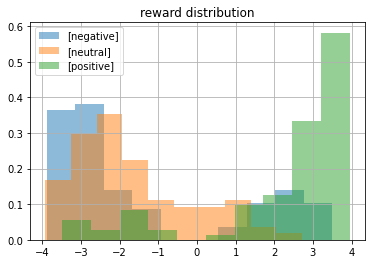

In [42]:
for ctrl_s in ctrl_str:
    plt.hist([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s],
             density=True,
             alpha=0.5,
             label=ctrl_s)
plt.legend(loc='best')
plt.title('reward distribution')
plt.grid(True)
plt.show()

# Examples

In [43]:
#### get a batch from the dataset
bs = 32
game_data = dict()
df_batch = df.sample(bs)
query_list = df_batch['query'].tolist()
game_data['query'] = query_list
for ctrl in ctrl_str:
    task_list = [ctrl] * bs
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])

    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)

    #### get response from gpt2 and gpt2_ref
    response_tensors  = respond_to_batch(gpt2_model, query_tensors, txt_len=config['txt_out_len'])
    game_data['response ' + ctrl] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(bs)]

    #### sentiment analysis of query/response pairs before/after
    texts = [q + r for q,r in zip(game_data['query'], game_data['response ' + ctrl])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    rewards = sentiment_model.forward(sentiment_inputs, attention_masks)[0][:, 1].detach()
    game_data['rewards ' + ctrl] = pos_logit_to_reward(rewards, task_list).cpu().numpy()

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response [negative],rewards [negative],response [neutral],rewards [neutral],response [positive],rewards [positive]
0,دعوني أعترف أنني لم أتوقع ي,كن بعد قراءتها في ت,-3.288068,قرأ هذا الكتاب عل�,-1.361892,ك أقرأ هذه الرواية,2.795119
1,الشيء الذي جعل من نجيب محفوظ,في هذا الكتاب ولكن ال,-2.111170,في هذا الكتاب لكن �,0.212068,في هذا الكتاب هو قب,-1.211214
2,عودة لعالم يوسف زيدان الممتع و الم,ق في هذا الكتاب ان ال,-3.927203,قرأ على هذا الكتا�,-3.854846,قور في هذا الكتاب ع,3.955179
3,روايه ملحميه رائعه الجمال تصوي,ر هذا القن في هذه ال�,-3.598559,ر على هذه الرواقه ه,-3.126479,ر في هذا الكتاب بعد �,3.580832
4,إنّها قصص قصيرة. ولكنّها,لم تكن الرواية تصور,-1.647560,في هذا الكتاب إلا من,-1.276457,لم تكن على تلك ال�,1.262285
5,للأسف هما خمس نجوم. :( | إذا,كان هذا الكتاب إخ�,-3.794666,هذا كان في هذه الق,-3.352003,كان هذا الكتاب وه في,3.703187
6,"قصه قصيرة خفيفه, أسلوبه الو",اقع. لكن لم يكن ب,0.171038,اقع لكن هذه الرواية,0.632724,اقع في هذا الكتاب ه,2.880918
7,اول تجاربى مع محمد عفيفى و,لكن هذا الكتاب لا ي,2.147730,لكن هذا الكتاب يتص,2.495530,لكن فى روايته و ت�,2.877103
8,عندما قرأت هذا الكتاب في تل�,� الرواية. و لكنف روا,-1.930244,� الرواية، ولكن أن أت,0.539059,� الرواية هذا الكتاب ك,3.223185
9,الشفاعة محاولة لفهم كيفية ال�,�ياة في الرواية، لم ي,3.291767,�ياة في الحياة. لن ت�,-0.444345,�ياة في هذه الرواية إ,3.028796


The mean and median reward clearly reflect that the model performs

In [44]:
print('mean:')
display(df_results.mean())
print()
print('median:')
display(df_results.median())

mean:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


rewards [negative]   -1.057171
rewards [neutral]    -1.745102
rewards [positive]    2.285692
dtype: float32


median:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


rewards [negative]   -2.112216
rewards [neutral]    -2.161420
rewards [positive]    3.152290
dtype: float32

# Controlled continuation

In [53]:
input_string = '[negative] هذا الكتاب'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' لم يحتل كتب في هذ'

In [54]:
input_string = '[negative] هذا الكتاب'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings


' لكن لم يكن في هذ'

In [55]:
input_string = '[positive] هذا الكتاب'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' هو يقرأ في هذا ال�'

In [56]:
input_string = '[positive] هذه الرواية'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' قصة في كتاب هذه الر'

# Mixed continuation

In [57]:
input_string = '[negative] الرواية كانت'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings


' من المقوم ولكن في هذ'

In [65]:
input_string = '[positive] الكاتب'
input_string += " الاسلوب كان بسيط جدا والطريقة سهلة جدا في الكتابة."
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=100)
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings


' يجعر راك الكتاب 1024 في حتلا هذه الفي هذا أن الم تجث كل عل النغيأك601 عن ث النفي عكر فسل 1986 عجه في فات�'

# Save model

In [66]:
gpt2_model.save_pretrained('gpt2-argoodreads-ctrl')
gpt2_tokenizer.save_pretrained('gpt2-argoodreads-ctrl')

('gpt2-argoodreads-ctrl/tokenizer_config.json',
 'gpt2-argoodreads-ctrl/special_tokens_map.json',
 'gpt2-argoodreads-ctrl/vocab.json',
 'gpt2-argoodreads-ctrl/merges.txt',
 'gpt2-argoodreads-ctrl/added_tokens.json')

In [67]:
!zip -r gpt2-argoodreads-ctrl.zip gpt2-argoodreads-ctrl/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: gpt2-argoodreads-ctrl/ (stored 0%)
  adding: gpt2-argoodreads-ctrl/vocab.json (deflated 63%)
  adding: gpt2-argoodreads-ctrl/merges.txt (deflated 53%)
  adding: gpt2-argoodreads-ctrl/pytorch_model.bin (deflated 9%)
  adding: gpt2-argoodreads-ctrl/config.json (deflated 52%)
  adding: gpt2-argoodreads-ctrl/special_tokens_map.json (deflated 72%)
  adding: gpt2-argoodreads-ctrl/tokenizer_config.json (deflated 67%)
